In [2]:
import pandas as pd
data = pd.read_parquet('Hiring_Problem_Statement/Hiring_Problem_Statement/Data_CaseStudy_1_small.pq')

print(data.head())
print(data.info())
print(data.describe())


     img_id                       category  Label       0      1       2  \
51       51  peolpe_and_villages_in_Africa  Train  4309.0  602.0  1020.0   
363     363                            bus  Train  4892.0  400.0  2575.0   
73       73  peolpe_and_villages_in_Africa  Train  4127.0  635.0  1287.0   
367     367                            bus  Train  4438.0  305.0  2899.0   
420     420                            bus  Train  4935.0  434.0  2210.0   

         3      4      5      6  ...      4026      4027      4028      4029  \
51   792.0  590.0  125.0  643.0  ...  0.124934  0.063436  0.027951  0.012870   
363  569.0  363.0   83.0  568.0  ...  0.036895  0.047161  0.000000  0.020553   
73   775.0  490.0  103.0  668.0  ...  0.180247  0.220398  0.227136  0.056666   
367  500.0  343.0   61.0  564.0  ...  0.095865  0.335565  0.335565  0.306085   
420  486.0  468.0   71.0  558.0  ...  0.015085  0.058592  0.020550  0.017326   

         4030      4031      4032      4033      4034      403

In [10]:
print(data.columns)


Index(['img_id', 'category', 'Label', '0', '1', '2', '3', '4', '5', '6',
       ...
       '4026', '4027', '4028', '4029', '4030', '4031', '4032', '4033', '4034',
       '4035'],
      dtype='object', length=4039)


In [18]:
import numpy as np
import faiss
 
embedding_columns = [str(i) for i in range(4036)] # extract embedding and categories 
embeddings = data[embedding_columns].values.astype('float32') 
categories = data['category'].values

In [19]:
d = embeddings.shape[1]  # Dimension of embeddings
index = faiss.IndexFlatL2(d)  # L2 distance search
index.add(embeddings)


In [20]:

k = 10
distances, indices = index.search(embeddings, k)  # query each embed

# calc P & Re 
precision_list = []
recall_list = []

for i in range(len(embeddings)):
    query_category = categories[i]
    retrieved_indices = indices[i]
    retrieved_categories = categories[retrieved_indices]
    
    correct = np.sum(retrieved_categories == query_category)
    # P
    precision = correct / k
    precision_list.append(precision)
    # Re
    total_relevant = np.sum(categories == query_category) - 1
    recall = correct / total_relevant if total_relevant > 0 else 0
    recall_list.append(recall)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)

print(f"Avg Precision: {avg_precision:.4f}")
print(f"Avg Recall: {avg_recall:.4f}")


Avg Precision: 0.5829
Avg Recall: 0.0832


                               precision    recall
category                                          
beaches                         0.373529  0.055751
bus                             0.881081  0.120696
dinosaurs                       0.953846  0.123876
elephants                       0.357534  0.049658
flowers                         0.744444  0.104851
foods                           0.414286  0.066820
horses                          0.695312  0.110367
monuments                       0.368333  0.062429
mountains_and_snow              0.398611  0.056142
peolpe_and_villages_in_Africa   0.551316  0.073509


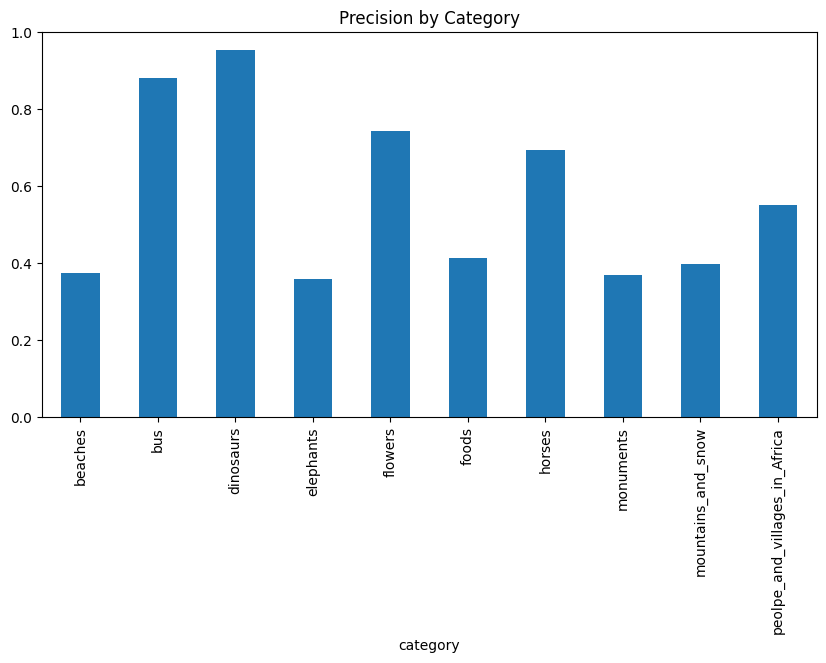

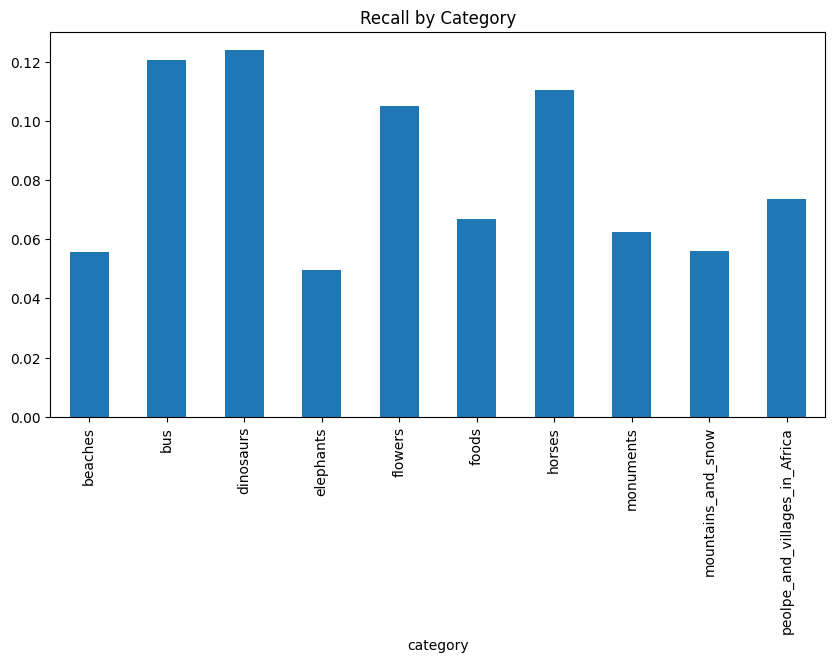

In [21]:
import pandas as pd

results = pd.DataFrame({
    'category': categories,
    'precision': precision_list,
    'recall': recall_list
})

# Group by category and calculate the mean precision and recall
category_metrics = results.groupby('category').mean()
print(category_metrics)

# Visualize per-category precision
import matplotlib.pyplot as plt
category_metrics['precision'].plot(kind='bar', figsize=(10 , 5), title='Precision by Category')
plt.show()

# Visualize per-category recall
category_metrics['recall'].plot(kind='bar', figsize=(10,5), title='Recall by Category')
plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(embeddings)


In [ ]:
from sklearn.linear_model import Ridge
import numpy as np

unique_categories = np.unique(categories)
centroids = {}
for cat in unique_categories:
    centroids[cat] = embeddings_normalized[categories == cat].mean(axis=0)
target_embeddings = np.array([centroids[cat] for cat in categories])

L2 = Ridge(alpha=1.0)
L2.fit(embeddings_normalized, target_embeddings)
W = L2.coef_.T  # Shape (4036, 4036)
embeddings_transformed = embeddings_normalized @ W


In [ ]:
from sklearn.neighbors import NearestNeighbors

def compute_precision(embeddings_input, categories, k=10):
    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(embeddings_input)

    precision_list = []

    for i in range(len(embeddings_input)):
        query_embedding = embeddings_input[i].reshape(1, -1)
        query_category = categories[i]

        distances, indices = nn.kneighbors(query_embedding)
        retrieved_categories = categories[indices[0]]

        correct = np.sum(retrieved_categories == query_category)
        precision = correct / k
        precision_list.append(precision)

    return np.mean(precision_list)


In [14]:
k = 10
precision_before = compute_precision(embeddings_normalized, categories, k)
precision_after = compute_precision(embeddings_transformed, categories, k)

print(f"Average Precision before transformation: {precision_before:.4f}")
print(f"Average Precision after transformation: {precision_after:.4f}")


Average Precision before transformation: 0.6093
Average Precision after transformation: 1.0000


In [15]:
def compute_recall(embeddings_input, categories, k=10):
    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(embeddings_input)

    recall_list = []

    for i in range(len(embeddings_input)):
        query_embedding = embeddings_input[i].reshape(1, -1)
        query_category = categories[i]

        distances, indices = nn.kneighbors(query_embedding)
        retrieved_categories = categories[indices[0]]

        correct = np.sum(retrieved_categories == query_category)

        # Total relevant excluding itself
        total_relevant = np.sum(categories == query_category) - 1
        if total_relevant > 0:
            recall = correct / total_relevant
        else:
            recall = 0  # or you can choose to skip this case
        recall_list.append(recall)

    return np.mean(recall_list)


In [16]:
recall_before = compute_recall(embeddings_normalized, categories, k)
recall_after = compute_recall(embeddings_transformed, categories, k)

print(f"Average Recall before transformation: {recall_before:.4f}")
print(f"Average Recall after transformation: {recall_after:.4f}")


Average Recall before transformation: 0.0872
Average Recall after transformation: 0.1449


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File

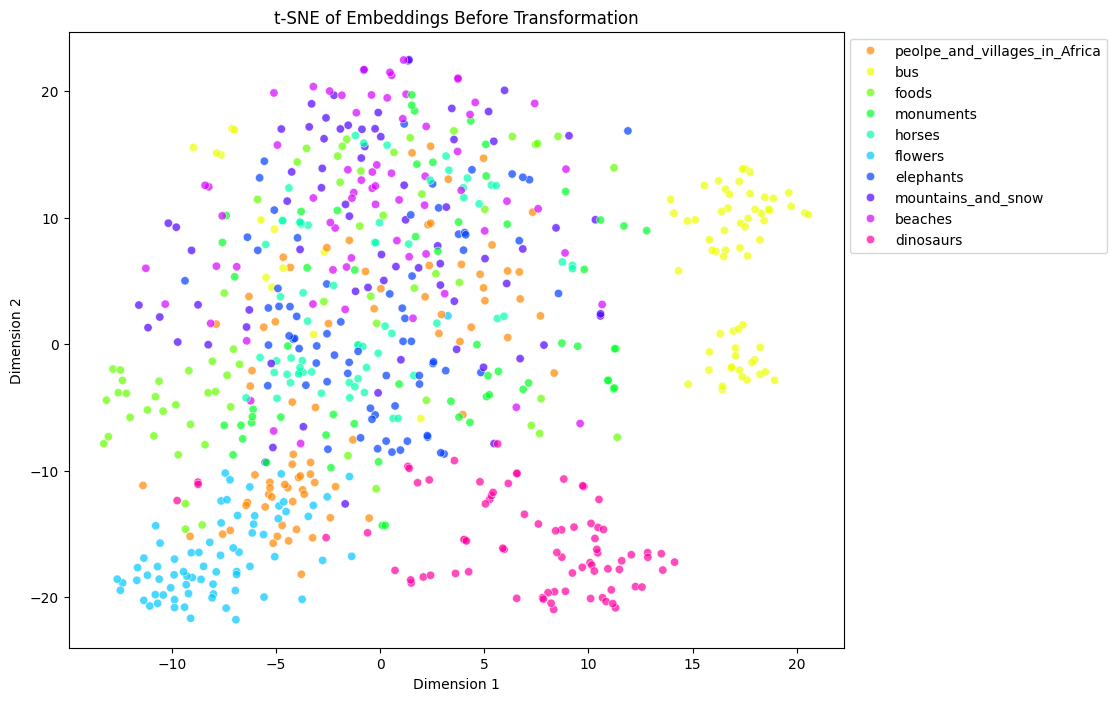

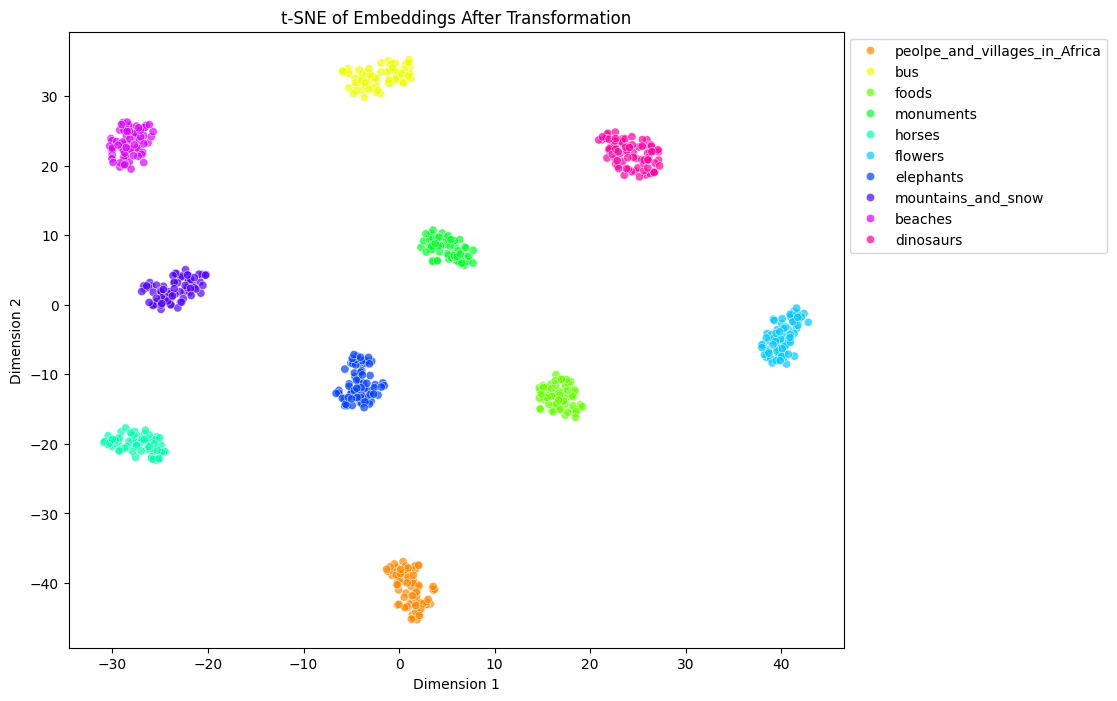

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Reduce dimensionality to 2D for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE on original normalized embeddings
embeddings_2d_before = tsne.fit_transform(embeddings_normalized)
embeddings_2d_after = tsne.fit_transform(embeddings_transformed)

# plot embeddings
def plot_embeddings(embeddings_2d, categories, title):
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("hsv", len(np.unique(categories)))

    sns.scatterplot(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        hue=categories,
        palette=palette,
        legend='full',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.show()
plot_embeddings(embeddings_2d_before, categories, "t-SNE of Embeddings Before Transformation")
plot_embeddings(embeddings_2d_after, categories, "t-SNE of Embeddings After Transformation")
